In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from ecg.detection import oxi_peaks
from ecg.utils import heart_rate
from ecg.epochs import to_epochs
from pingouin import madmedianrule

In [2]:
path = 'C:/Users/au646069/Google Drive/ECG_root/Projects/in_progress/EmotionalMetaMemory/data/Data/'
results_path = 'C:/Users/au646069/Google Drive/ECG_root/Projects/in_progress/EmotionalMetaMemory/figures/results/HeartRate/'

# Extract heart rate

In [ ]:
subjects = [f for f in os.listdir(path) if len(f) == 5]
for nSub in subjects:

    # Find files name
    for file in os.listdir(path + nSub):
        if file.endswith(".txt") & file.startswith('Subject'):
            df = pd.read_csv(os.path.join(path + nSub, file))
        elif file.endswith('9.npy'):
            nSub2 = file[:len(file) - 5]

    # Start loop 
    for val in ['Low', 'High']:
        for aro in ['Low', 'High']:
            for learningTime in [30, 60, 90]:
                # Get block numbers
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]
                bl = this_df.nBlock.iloc[0]
                oxi = np.load(path + nSub + '/' + nSub2 + str(int(bl)) + '.npy', allow_pickle=True)[0]
                triggers = np.load(path + nSub + '/' + nSub2 + str(int(bl)) + '.npy', allow_pickle=True)[1][:-1]

                # Find peaks
                peaks = oxi_peaks(oxi, resample=True, new_sfreq=300)

                # Extract instantaneous heartrate
                hr, time = heart_rate(peaks, sfreq=300, unit='bpm', method='staircase')
                
                # Save to new array
                new = np.vstack([np.asarray(hr[::4]), np.asarray(triggers)])
                np.save(path + nSub + '/' + nSub2 + str(int(bl)) + '-raw.npy', new)

# Maximum-minimum heart rate

In [23]:
features_df = pd.DataFrame([])
subjects = [f for f in os.listdir(path) if len(f) == 5]
for nSub in subjects:

    # Find files name
    for file in os.listdir(path + nSub):
        if file.endswith(".txt") & file.startswith('Subject'):
            df = pd.read_csv(os.path.join(path + nSub, file))
        elif file.endswith('9.npy'):
            nSub2 = file[:len(file) - 5]

    # Start loop 
    for val in ['Low', 'High']:
        for aro in ['Low', 'High']:
            for learningTime in [30, 60, 90]:
                # Get block numbers
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]
                bl = this_df.nBlock.iloc[0]
                recording = np.load(path + nSub + '/' + nSub2 + str(int(bl)) + '-raw.npy')

                # Epoch recording
                epoch = to_epochs(recording[0], recording[1], sfreq=75, event_idx=2, tmin=0, tmax=6, sigma=20)

                # Outlier rejection
                # drop_out = ~madmedianrule(np.max(np.abs(epoch), axis=1))

                # Decimate
                features_df = features_df.append(pd.DataFrame({'Min': [np.median(epoch.min(axis=1))],
                                               'Max': [np.median(epoch.min(axis=1))],
                                               'Arousal': aro,
                                               'Valence': val,
                                               'LearningTime': learningTime,
                                               'Subject': nSub}))

1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/au646069/Google Drive/ECG_root/Projects/in_progress/EmotionalMetaMemory/data/Data/11114/Subject_11114107-raw.npy'

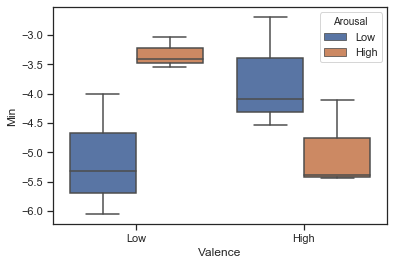

In [22]:
sns.boxplot(data=features_df, x='Valence', y='Min', hue='Arousal')

In [ ]:
# Plot results
plt.figure(figsize=(18, 8))

# Arousal * Valence
plt.subplot(131)
sns.lineplot(data=features_df, x='Time', y='value', hue='Valence', style='Arousal', ci=68)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylim(-10, 4)

# Learning time
plt.subplot(132)
sns.lineplot(data=results_df, x='Time', y='value', hue='LearningTime', ci=68, palette=sns.cubehelix_palette(3))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylim(-10, 4)

# Model fits
plt.subplot(133)
sns.lineplot(data=total_corr, x='Time', y='Correlation', hue='Valence', style='Arousal', units='LearningTime', estimator=None)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylim(-5, 5)

plt.savefig(results_path + str(nSub) + '.png', dpi=600)
plt.close()

# Heart rate modulation

In [137]:
subjects = [f for f in os.listdir(path) if len(f) == 5]
final_df = pd.DataFrame([])
for nSub in subjects:

    # Find files name
    for file in os.listdir(path + nSub):
        if file.endswith(".txt") & file.startswith('Subject'):
            df = pd.read_csv(os.path.join(path + nSub, file))
        elif file.endswith('9.npy'):
            nSub2 = file[:len(file) - 5]

    # Start loop 
    results_df, total_corr = pd.DataFrame([]), pd.DataFrame([])
    for val in ['Low', 'High']:
        for aro in ['Low', 'High']:
            for learningTime in [30, 60, 90]:
                # Get block numbers
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]
                bl = this_df.nBlock.iloc[0]
                oxi = np.load(path + nSub + '/' + nSub2 + str(int(bl)) + '.npy', allow_pickle=True)[0]
                triggers = np.load(path + nSub + '/' + nSub2 + str(int(bl)) + '.npy', allow_pickle=True)[1]

                # Find peaks
                peaks = oxi_peaks(oxi, resample=False)

                # Extract instantaneous heartrate
                hr, time = heart_rate(peaks, sfreq=75, unit='bpm', method='staircase')

                # Epoch recording
                epoch = to_epochs(hr, np.asarray(triggers), sfreq=75, event_idx=2, tmin=0, tmax=6, sigma=20)

                # Outlier rejection
                drop_out = ~madmedianrule(np.max(np.abs(epoch), axis=1))

                # Decimate
                epoch = epoch[:, ::5]

                epochs_df = pd.DataFrame(epoch[drop_out]).melt()
                epochs_df['Arousal'] = aro
                epochs_df['Valence'] = val
                epochs_df['LearningTime'] = learningTime
                epochs_df['LearningTime'] = epochs_df['LearningTime'].astype('category')
                epochs_df['Time'] = (epochs_df['variable']/15)
                epochs_df['Subject'] = nSub

                # Correlations
                drop = (this_df.Confidence != 'Nan') & drop_out
                l = []
                for i in range(epoch.shape[1]):
                    reg = LinearRegression().fit(np.asarray(this_df.Confidence[drop]).reshape(-1, 1), np.asarray(epoch[drop, i]).reshape(-1, 1))
                    l.append(reg.coef_[0][0])
                
                correlation_df = pd.DataFrame([])
                correlation_df['Correlation'] = l
                correlation_df['Time'] = np.arange(0, len(l))/15
                correlation_df['Arousal'] = aro
                correlation_df['Valence'] = val
                correlation_df['LearningTime'] = learningTime
                correlation_df['Subject'] = nSub

                total_corr = total_corr.append(correlation_df)
                results_df = results_df.append(epochs_df)
                
                final_df = final_df.append(pd.DataFrame({'Arousal':aro,
                                                         'Valence': val,
                                                         'LearningTime': learningTime,
                                                         'Time': np.arange(0, len(l))/15,
                                                         'Subject': nSub,
                                                         'BPM': epoch[drop_out].mean(0),
                                                         'Beta': l}))
    
    # Plot results
    plt.figure(figsize=(18, 8))

    # Arousal * Valence
    plt.subplot(131)
    sns.lineplot(data=results_df, x='Time', y='value', hue='Valence', style='Arousal', ci=68)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axvline(x=0, linestyle='--', color='k')
    plt.ylim(-10, 4)

    # Learning time
    plt.subplot(132)
    sns.lineplot(data=results_df, x='Time', y='value', hue='LearningTime', ci=68, palette=sns.cubehelix_palette(3))
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axvline(x=0, linestyle='--', color='k')
    plt.ylim(-10, 4)

    # Model fits
    plt.subplot(133)
    sns.lineplot(data=total_corr, x='Time', y='Correlation', hue='Valence', style='Arousal', units='LearningTime', estimator=None)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axvline(x=0, linestyle='--', color='k')
    plt.ylim(-5, 5)

    plt.savefig(results_path + str(nSub) + '.png', dpi=600)
    plt.close()

1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent re

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent re

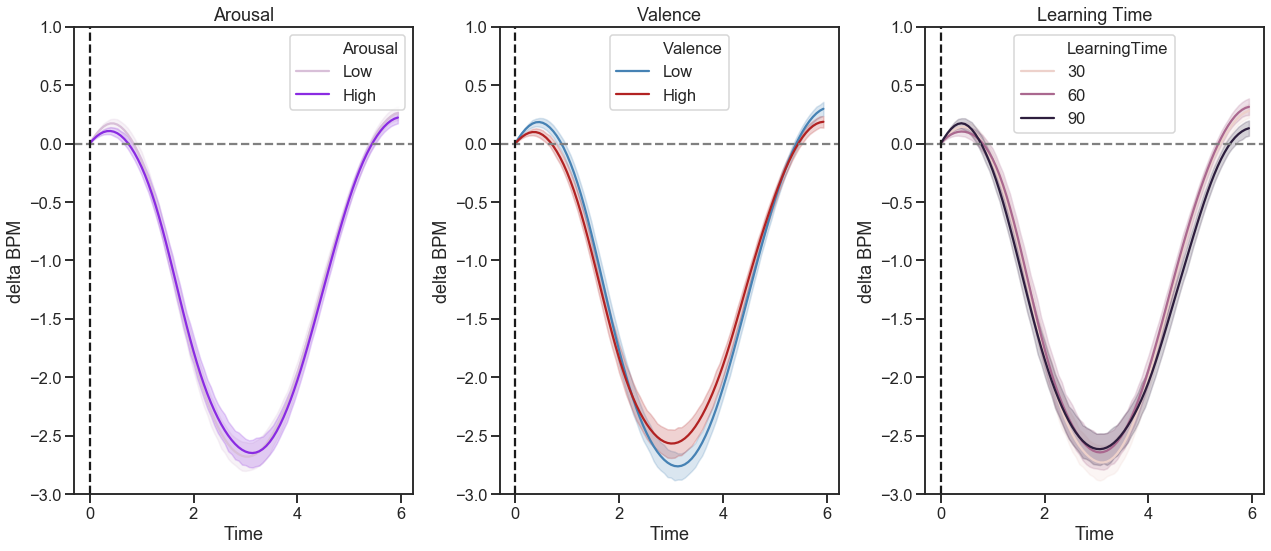

In [169]:
sns.set_context('talk')

# Plot results
plt.figure(figsize=(18, 8))

# Arousal
plt.subplot(131)
sns.lineplot(data=final_df, x='Time', y='BPM', hue='Arousal', ci=68, palette=['thistle', 'blueviolet'])
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylim(-3, 1)
plt.ylabel('delta BPM')
plt.title('Arousal')

# Valence
plt.subplot(132)
sns.lineplot(data=final_df, x='Time', y='BPM', hue='Valence', ci=68, palette=['steelblue', 'firebrick'])
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylim(-3, 1)
plt.ylabel('delta BPM')
plt.title('Valence')

# Learning time
plt.subplot(133)
sns.lineplot(data=final_df, x='Time', y='BPM', hue='LearningTime', ci=68, palette=sns.cubehelix_palette(3))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylim(-3, 1)
plt.ylabel('delta BPM')
plt.title('Learning Time')

plt.tight_layout()

plt.savefig(results_path + 'bpm.png', dpi=600)

# Linear models

In [35]:
subjects = [f for f in os.listdir(path) if len(f) == 5]
final_df = pd.DataFrame([])
for nSub in subjects[:1]:

    # Find files name
    for file in os.listdir(path + nSub):
        if file.endswith(".txt") & file.startswith('Subject'):
            df = pd.read_csv(os.path.join(path + nSub, file))
        elif file.endswith('9.npy'):
            nSub2 = file[:len(file) - 5]

    # Start loop 
    results_df, total_corr = pd.DataFrame([]), pd.DataFrame([])
    for val in ['Low', 'High']:
        for aro in ['Low', 'High']:

            X, y = [], []
            for learningTime in [30, 60, 90]:
                # Get block numbers
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]
                bl = this_df.nBlock.iloc[0]
                oxi = np.load(path + nSub + '/' + nSub2 + str(int(bl)) + '.npy', allow_pickle=True)[0]
                triggers = np.load(path + nSub + '/' + nSub2 + str(int(bl)) + '.npy', allow_pickle=True)[1]

                # Find peaks
                peaks = oxi_peaks(oxi, resample=True, new_sfreq=300)

                # Extract instantaneous heartrate
                hr, time = heart_rate(peaks, sfreq=75, unit='bpm', method='staircase')

                # Epoch recording
                epoch = to_epochs(hr[::4], np.asarray(triggers), sfreq=75, event_idx=2, tmin=0, tmax=6, sigma=20)

                # Outlier rejection
                drop_outliers = ~madmedianrule(np.max(np.abs(epoch), axis=1))
                drop = (this_df.Confidence != 'Nan') & drop_outliers

                # Decimate
                epoch = epoch[:, ::5]

                # Correlations
                X.extend(this_df.Confidence[drop].to_list())
                y.extend(epoch[drop, :])
            
            # Model fit
            l = []
            for i in range(epoch.shape[1]):
                reg = LinearRegression().fit(np.asarray(X).reshape(-1, 1).astype(np.float64),
                             np.asarray(y)[:, i].reshape(-1, 1).astype(np.float64))
                l.append(reg.coef_[0][0])

            final_df = final_df.append(pd.DataFrame({'Arousal':aro,
                                                     'Valence': val,
                                                     'LearningTime': learningTime,
                                                     'Time': np.arange(0, len(l))/15,
                                                     'Subject': nSub,
                                                     'BPM': epoch[drop].mean(0),
                                                     'Beta': l}))

1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording
1 trial(s) droped due to inconsistent recording


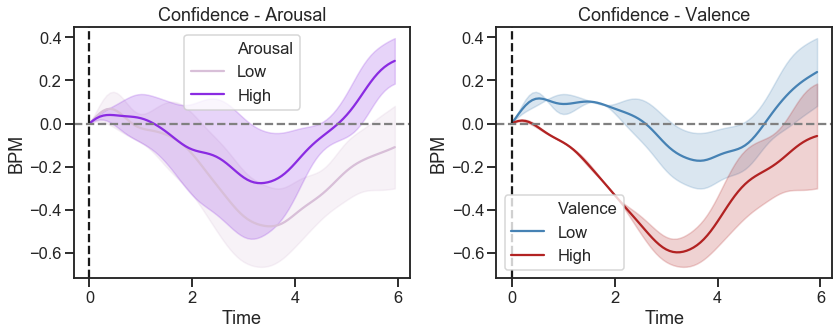

In [36]:
sns.set_context('talk')
plt.figure(figsize=(12, 5))

# Model fits - Arousal
plt.subplot(121)
sns.lineplot(data=final_df, x='Time', y='BPM', hue='Arousal', ci=68, palette=['thistle', 'blueviolet'])
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.title('Confidence - Arousal')

# Model fits - Valence
plt.subplot(122)
sns.lineplot(data=final_df, x='Time', y='BPM', hue='Valence', ci=68, palette=['steelblue', 'firebrick'])
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.title('Confidence - Valence')

plt.tight_layout()
plt.savefig(results_path + 'confidence.png', dpi=600)